# Human activity detection inside car from still frames.
### by Subham Das CS21S058

# Imports

In [2]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import pandas_profiling

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

# Visualizing and preparing data

In [3]:
root_folder = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
classes = sorted([c for c in os.listdir(root_folder) if not c.startswith(".")])
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [4]:
class_dict = {
              0 : "safe driving",
              1 : "texting - right",
              2: "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9: "talking to a passenger"}

In [5]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(root_folder,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)

In [6]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

In [8]:
data_for_visualisation = datasets.ImageFolder(root = root_folder,transform=transform)

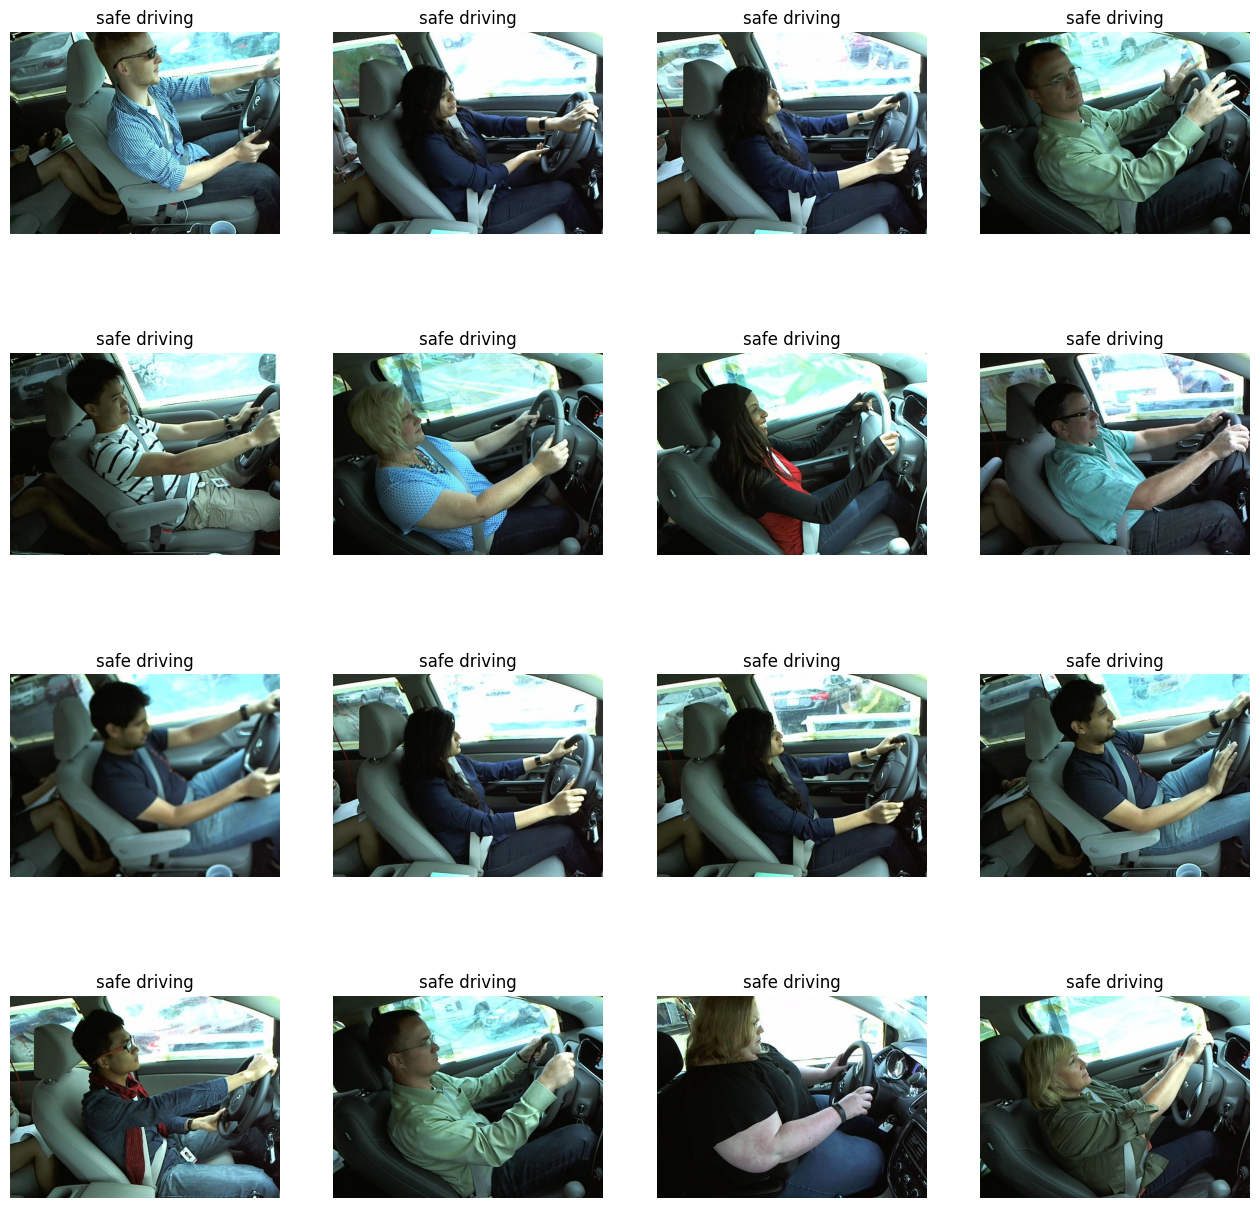

In [9]:
import itertools
n_rows, n_cols = 4, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize = (n_rows*4,n_cols*4))
for i, (r, c) in enumerate(itertools.product(range(n_rows), range(n_cols))):
    axs[r,c].imshow(data_for_visualisation[i][0].permute(1,2,0))
    axs[r,c].set_title(class_dict[data_for_visualisation[i][1]])
    axs[r,c].axis('off')

# Creating and training the model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

In [12]:
data = datasets.ImageFolder(root = root_folder, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [14]:
def train_step(optimizer,model,criterion,epoch):
    running_loss = 0.0
    running_correct = 0.0
    for data in train_loader:

        # get the inputs and assign them to cuda
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # calculate the loss/acc later
        running_loss += loss.item()
        running_correct += (labels==predicted).sum().item()

    
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100/32*running_correct/len(train_loader)

   
    return epoch_loss,epoch_acc

In [15]:
def eval_step(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    
    return test_acc

In [16]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):  
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        epoch_loss,epoch_acc=train_step(optimizer,model,criterion,epoch)
        epoch_duration = time.time()-since
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_step(model)
        print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [17]:
#pretrained_model = models.resnet50(pretrained=True)
pretrained_model = torchvision.models.mobilenet_v3_small(pretrained = True)

num_ftrs = pretrained_model.classifier[3].in_features

pretrained_model.classifier[3] = nn.Linear(num_ftrs, 10) #No. of classes = 10
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 53.5MB/s]


In [18]:
pretrained_model, training_losses, training_accs, test_accs = train_model(pretrained_model, criterion, optimizer, lrscheduler, n_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, duration: 194 s, loss: 0.4229, acc: 87.0544


 33%|███▎      | 1/3 [03:58<07:57, 238.72s/it]

Accuracy of the network on the test images: 89 %
Epoch 2, duration: 164 s, loss: 0.0450, acc: 98.7021


 67%|██████▋   | 2/3 [07:22<03:38, 218.19s/it]

Accuracy of the network on the test images: 96 %
Epoch 3, duration: 171 s, loss: 0.0260, acc: 99.1422


100%|██████████| 3/3 [10:53<00:00, 217.79s/it]

Accuracy of the network on the test images: 98 %
Finished Training


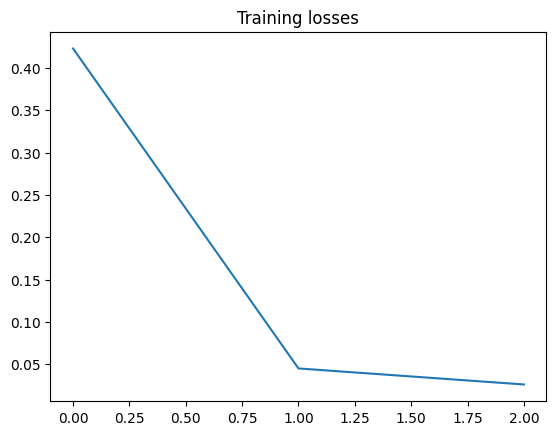

In [19]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

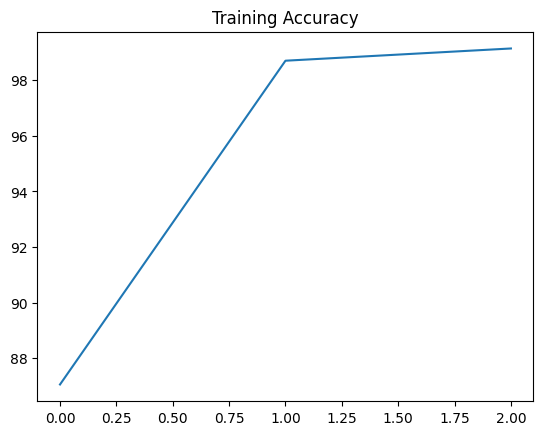

In [20]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

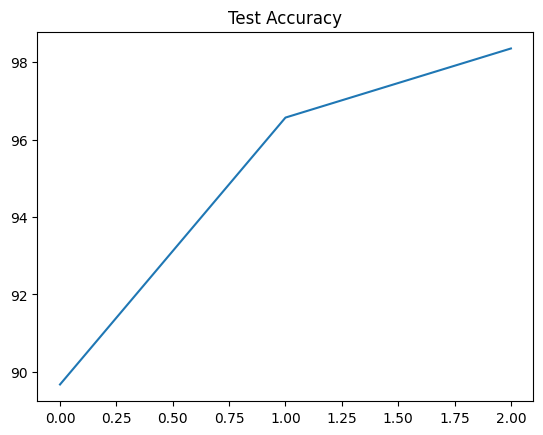

In [21]:
plt.title('Test Accuracy')
plt.plot(test_accs)
plt.show()

In [22]:
torch.save(pretrained_model.state_dict(), "/kaggle/working/model-driver")